# REQUIREMENTS

In [1]:
import wrds, datetime
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'

conn = wrds.Connection()

# veervohra
# rzoj3miTfgD$

Loading library list...
Done


# DATA COLLECTION

### S&P DATA

In [2]:
sp500_data = conn.raw_sql("""
SELECT
    date,
    vwretd AS market_return
FROM
    crsp.msi
WHERE
    date >= '1986-10-29'
ORDER BY
    date;
""")

sp500_data['date'] = pd.to_datetime(sp500_data['date'])

sp500_data.set_index('date', inplace=True)

sp500_data['market_quarterly_return'] = (
    sp500_data['market_return']
    .rolling(window=3, min_periods=3)
    .apply(lambda x: (1 + x).prod() - 1, raw=True)
)

sp500_data.reset_index(inplace=True)

sp500_data

,date,market_return,market_quarterly_return
0,1986-10-31,0.049305,NaN
1,1986-11-28,0.015093,NaN
2,1986-12-31,-0.026387,0.037036
3,1987-01-30,0.128499,0.115304
4,1987-02-27,0.047922,0.151374
...,...,...,...
442,2023-08-31,-0.020605,0.081413
443,2023-09-29,-0.047390,-0.033782
444,2023-10-31,-0.028867,-0.093951
445,2023-11-30,0.092057,0.010274


### FACTORS & RFR

##### (1-month Treasury bill rate)
##### Beginning of Month

In [3]:
factors = conn.raw_sql('''
    SELECT
        date,
        mktrf AS market_factor,  -- Market factor (excess return on the market)
        smb AS size_factor,  -- Size factor (Small Minus Big)
        hml AS value_factor,  -- Value factor (High Minus Low)
        umd AS momentum_factor,  -- Momentum factor
        rf AS risk_free_rate -- One Month Treasury Bill Rate (daily)
    FROM
        ff.factors_monthly
''')

factors

,date,market_factor,size_factor,value_factor,momentum_factor,risk_free_rate
0,1926-07-01,0.0296,-0.0256,-0.0243,NaN,0.0022
1,1926-08-01,0.0264,-0.0117,0.0382,NaN,0.0025
2,1926-09-01,0.0036,-0.0140,0.0013,NaN,0.0023
3,1926-10-01,-0.0324,-0.0009,0.0070,NaN,0.0032
4,1926-11-01,0.0253,-0.0010,-0.0051,NaN,0.0031
...,...,...,...,...,...,...
1174,2024-05-01,0.0434,0.0078,-0.0166,-0.0002,0.0044
1175,2024-06-01,0.0277,-0.0306,-0.0331,0.0090,0.0041
1176,2024-07-01,0.0124,0.0680,0.0573,-0.0242,0.0045
1177,2024-08-01,0.0161,-0.0355,-0.0113,0.0479,0.0048


### COMPANY DATA

In [4]:
#gets ID (permno) and earliest recorded name for each company in CRSP database. There are 37,776 companies available to us.
conn.raw_sql( '''
SELECT permno, MIN(comnam) AS company_name
FROM crsp.stocknames
GROUP BY permno
''')

,permno,company_name
0,83264,GREIF BROTHERS CORP
1,63618,HINDERLITER ENERGY EQUIP CORP
2,10896,CAMILLE ST MORITZ INC
3,69906,SEIBELS BRUCE GROUP INC
4,79030,GREAT CENTRAL MINES LTD
...,...,...
37771,14886,ARK E T F TRUST
37772,79163,A M F M INC
37773,86036,BRENTWOOD INSTRUMENTS INC
37774,92970,CHINA EDUCATION ALLIANCE INC


In [5]:
#Using NVIDIA as example to figure out the algorithm.

conn.raw_sql('''
SELECT *
FROM crsp.ccmxpf_linktable
WHERE lpermno = 86580;
''')

,gvkey,linkprim,liid,linktype,lpermno,lpermco,usedflag,linkdt,linkenddt
0,117768,P,01,LU,86580.0,16382.0,1.0,1999-01-22,None


In [6]:
#Getting NVIDIA time series data.

nvidia = conn.raw_sql('''
WITH comp_data AS (
    SELECT
        f.gvkey,
        f.datadate AS date,
        f.atq AS total_assets,  -- Total Assets
        f.chq AS cash_holdings,  -- Cash and Short-Term Investments
        f.dlttq + f.dlcq AS total_debt,  -- Total Debt (long-term + short-term debt)
        f.ibq AS earnings,  -- Earnings before extraordinary items
        f.xrdq AS rd_expense,  -- R&D expense
        f.dvpq AS dividends_paid,  -- Dividends paid
        f.xintq AS interest_expense,  -- Interest expense
        f.prccq * f.cshoq AS market_cap,  -- Market cap (price * shares outstanding)
        f.rdq AS reporting_date -- Date of which information was reported
    FROM
        comp.fundq f
    WHERE
        gvkey = '117768'
        AND f.datadate >= '1990-01-01'  -- Ensure data is after the link start date
),
crsp_data AS (
    SELECT
        permno,
        date,
        ret AS stock_return,  -- Stock returns from CRSP
        prc AS stock_price,
        prc * shrout AS market_cap  -- Market cap
    FROM
        crsp.msf
    WHERE
        permno = 86580  -- Use the correct permno for gvkey 003243
)
SELECT
    c.gvkey,
    cr.permno,
    c.date, -- Date of each quarter (this is when the information was real)
    c.reporting_date, -- Reporting date (this is when information became known to us)
    cr.stock_price,
    c.cash_holdings,
    c.total_assets,
    c.market_cap,
    c.earnings,
    c.total_debt,
    c.rd_expense,
    c.dividends_paid,
    c.interest_expense
FROM
    comp_data c
JOIN
    crsp_data cr ON c.date = cr.date
ORDER BY
    c.gvkey, c.date;

''')

nvidia

,gvkey,permno,date,reporting_date,stock_price,cash_holdings,total_assets,market_cap,earnings,total_debt,rd_expense,dividends_paid,interest_expense
0,117768,86580,1999-04-30,1999-05-18,18.25000,NaN,126.656,5.370610e+02,6.261,3.156,8.785,0.0,NaN
1,117768,86580,2000-01-31,2000-02-15,37.06250,NaN,202.250,1.152644e+03,14.587,2.748,15.421,0.0,NaN
2,117768,86580,2000-07-31,2000-08-21,60.00000,NaN,507.183,3.927240e+03,22.522,1.776,20.141,0.0,NaN
3,117768,86580,2000-10-31,2000-11-09,62.14063,NaN,983.346,4.218727e+03,28.071,301.329,22.023,0.0,NaN
4,117768,86580,2001-01-31,2001-02-14,51.62500,NaN,1016.427,3.534041e+03,31.057,300.966,26.444,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,117768,86580,2022-01-31,2022-02-16,244.86000,1990.0,44187.000,6.136192e+05,3003.000,11831.000,1466.000,0.0,61.0
66,117768,86580,2022-10-31,2022-11-16,134.97000,2800.0,40488.000,3.331060e+05,680.000,11904.000,1944.000,0.0,66.0
67,117768,86580,2023-01-31,2023-02-22,195.37000,3389.0,41182.000,4.817824e+05,1414.000,12031.000,1952.000,0.0,64.0
68,117768,86580,2023-07-31,2023-08-23,467.29001,5783.0,49555.000,1.153739e+06,6189.000,10954.000,2041.000,0.0,65.0


## NOTES ON DATES

Company Data:
* Quarterly
* Start: 1999-04-30 (depends on company)
* End: 2023-11-21

Factors & RFR:
* Monthly (Beginning of Month)
* Start: 1926-07-01
* End: 2024-09-01

S&P:
* Monthly (End of Month)
* Start: 1986-10-31
* End: 2023-12-29

# CALCULATIONS (CASH-HEDGING & RETURNS)

In [7]:
#adding cash share & quarterly returns
nvidia['cash_share_weight'] = (nvidia['cash_holdings']/nvidia['total_assets']) #.shift(2) - why are we lagging here? lagging should be a pre-calculation adjustment
nvidia['quarterly_return'] = nvidia['stock_price'].pct_change(fill_method=None)

In [8]:
nvidia

,gvkey,permno,date,reporting_date,stock_price,cash_holdings,total_assets,market_cap,earnings,total_debt,rd_expense,dividends_paid,interest_expense,cash_share_weight,quarterly_return
0,117768,86580,1999-04-30,1999-05-18,18.25000,NaN,126.656,5.370610e+02,6.261,3.156,8.785,0.0,NaN,NaN,NaN
1,117768,86580,2000-01-31,2000-02-15,37.06250,NaN,202.250,1.152644e+03,14.587,2.748,15.421,0.0,NaN,NaN,1.030822
2,117768,86580,2000-07-31,2000-08-21,60.00000,NaN,507.183,3.927240e+03,22.522,1.776,20.141,0.0,NaN,NaN,0.618887
3,117768,86580,2000-10-31,2000-11-09,62.14063,NaN,983.346,4.218727e+03,28.071,301.329,22.023,0.0,NaN,NaN,0.035677
4,117768,86580,2001-01-31,2001-02-14,51.62500,NaN,1016.427,3.534041e+03,31.057,300.966,26.444,0.0,NaN,NaN,-0.169223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,117768,86580,2022-01-31,2022-02-16,244.86000,1990.0,44187.000,6.136192e+05,3003.000,11831.000,1466.000,0.0,61.0,0.045036,-0.592158
66,117768,86580,2022-10-31,2022-11-16,134.97000,2800.0,40488.000,3.331060e+05,680.000,11904.000,1944.000,0.0,66.0,0.069156,-0.448787
67,117768,86580,2023-01-31,2023-02-22,195.37000,3389.0,41182.000,4.817824e+05,1414.000,12031.000,1952.000,0.0,64.0,0.082293,0.447507
68,117768,86580,2023-07-31,2023-08-23,467.29001,5783.0,49555.000,1.153739e+06,6189.000,10954.000,2041.000,0.0,65.0,0.116699,1.391821


### $ b_{t}^{i} $ - Section 4 in RRR

In [9]:
'''

#firm-specific cash return estimate, based on Faulkender and Wang (2006) model

data = nvidia.copy()
data['market_cap'] = data['market_cap'].shift() # paper uses M_{t-1} for the denoms

# scaled change in each var
data['delta_cash'] = (data['cash_holdings'].diff()) / data['market_cap']
data['delta_earnings'] = (data['earnings'].diff()) / data['market_cap']
data['delta_net_assets'] = ((data['total_assets'] - data['cash_holdings']).diff()) / data['market_cap']
data['delta_r_and_d'] = (data['rd_expense'].diff()) / data['market_cap']
# delta interest expense
data['delta_dividends'] = (data['dividends_paid'].diff()) / data['market_cap']
# cash in t-1
data['leverage'] = data['total_debt'] / (data['total_debt'] + data['market_cap'])
data['net_financing'] = (data['total_debt'].diff() + data['market_cap'].diff()) / (data['total_debt'].shift() + data['market_cap'].shift())
# (cash in t-1) * (delta cash in t)
# (leverage) * (delta cash in t)


# 1. Calculate Marginal Cash Value

X = data[['delta_cash', 'delta_earnings', 'delta_net_assets',
          'delta_r_and_d', 'delta_dividends', 'leverage', 'net_financing']]
y = data['quarterly_return']

# must drop NaN values for the regression, but due to missing values we are left with very few data points (for nvidia at least)
X = X.dropna()
y = y.loc[X.index]

model = LinearRegression().fit(X, y)

# data['mcv'] = model.coef_[1] + (model.coef_[11] * data['cash_holdings'].shift() / data['market_cap']) + (model.coef_[12] * data['leverage']) # Marginal Cash Value
# data['acv'] = model.coef_[1] + (0.5 * ((model.coef_[11] * data['cash_holdings'].shift() / data['market_cap']))) + (model.coef_[12] * data['leverage']) # Average Cash Value
# data['fycr'] = data['acv'] / data['acv'].shift()

# 2. 


# 3. 


# 4. 


# b_it OUR METHOD

'''

"\n\n#firm-specific cash return estimate, based on Faulkender and Wang (2006) model\n\ndata = nvidia.copy()\ndata['market_cap'] = data['market_cap'].shift() # paper uses M_{t-1} for the denoms\n\n# scaled change in each var\ndata['delta_cash'] = (data['cash_holdings'].diff()) / data['market_cap']\ndata['delta_earnings'] = (data['earnings'].diff()) / data['market_cap']\ndata['delta_net_assets'] = ((data['total_assets'] - data['cash_holdings']).diff()) / data['market_cap']\ndata['delta_r_and_d'] = (data['rd_expense'].diff()) / data['market_cap']\n# delta interest expense\ndata['delta_dividends'] = (data['dividends_paid'].diff()) / data['market_cap']\n# cash in t-1\ndata['leverage'] = data['total_debt'] / (data['total_debt'] + data['market_cap'])\ndata['net_financing'] = (data['total_debt'].diff() + data['market_cap'].diff()) / (data['total_debt'].shift() + data['market_cap'].shift())\n# (cash in t-1) * (delta cash in t)\n# (leverage) * (delta cash in t)\n\n\n# 1. Calculate Marginal Cash 

### $ e_{t}^{i} $

In [10]:
# calculate the cash-hedged return e_it

nvidia['chs'] = nvidia['cash_holdings'].shift()
nvidia['b_it'] = ( nvidia['cash_holdings'] - nvidia['chs'] ) / nvidia['chs']

nvidia['cash_hedged_return'] = (1 / (1 - nvidia['cash_share_weight'])) * (nvidia['quarterly_return'] - (nvidia['cash_share_weight']  * nvidia['b_it']))

nvidia

,gvkey,permno,date,reporting_date,stock_price,cash_holdings,total_assets,market_cap,earnings,total_debt,rd_expense,dividends_paid,interest_expense,cash_share_weight,quarterly_return,chs,b_it,cash_hedged_return
0,117768,86580,1999-04-30,1999-05-18,18.25000,NaN,126.656,5.370610e+02,6.261,3.156,8.785,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,117768,86580,2000-01-31,2000-02-15,37.06250,NaN,202.250,1.152644e+03,14.587,2.748,15.421,0.0,NaN,NaN,1.030822,NaN,NaN,NaN
2,117768,86580,2000-07-31,2000-08-21,60.00000,NaN,507.183,3.927240e+03,22.522,1.776,20.141,0.0,NaN,NaN,0.618887,NaN,NaN,NaN
3,117768,86580,2000-10-31,2000-11-09,62.14063,NaN,983.346,4.218727e+03,28.071,301.329,22.023,0.0,NaN,NaN,0.035677,NaN,NaN,NaN
4,117768,86580,2001-01-31,2001-02-14,51.62500,NaN,1016.427,3.534041e+03,31.057,300.966,26.444,0.0,NaN,NaN,-0.169223,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,117768,86580,2022-01-31,2022-02-16,244.86000,1990.0,44187.000,6.136192e+05,3003.000,11831.000,1466.000,0.0,61.0,0.045036,-0.592158,978.0,1.034765,-0.668884
66,117768,86580,2022-10-31,2022-11-16,134.97000,2800.0,40488.000,3.331060e+05,680.000,11904.000,1944.000,0.0,66.0,0.069156,-0.448787,1990.0,0.407035,-0.512370
67,117768,86580,2023-01-31,2023-02-22,195.37000,3389.0,41182.000,4.817824e+05,1414.000,12031.000,1952.000,0.0,64.0,0.082293,0.447507,2800.0,0.210357,0.468773
68,117768,86580,2023-07-31,2023-08-23,467.29001,5783.0,49555.000,1.153739e+06,6189.000,10954.000,2041.000,0.0,65.0,0.116699,1.391821,3389.0,0.706403,1.482376


# BETA CALCULATION

Seems like in some instances cash_hedged_returns is getting super over inflated. Ideally, that is what we want! But will need to make sure the raise in risk is also reflected.

Next steps:
* Calculate Beta for non-cash assets in NVIDIA
* Use above data to test returns in cash-hedged for NVIDIA over time (long-only) 
* (etc)

Calculating Stock Beta and Cash-Hedged Beta (PiT).

In [11]:
def rolling_beta_grouped(df, window_size):
    
    def calc_rolling_beta(data):
        betas = []
        
        for start in range(len(data) - window_size + 1):
            window_data = data.iloc[start:start + window_size]

            X = sm.add_constant(window_data['snp_ret']) # (add constant for intercept)
            y = window_data['stock_ret']

            model = sm.OLS(y, X).fit()
            beta = model.params['snp_ret']
            betas.append(beta)
        
        beta_series = pd.Series(betas, index=data.index[window_size - 1:])
        return beta_series

    beta_results = df.groupby('permno').apply(calc_rolling_beta, include_groups=False)

    beta_results = beta_results.reset_index(level=0, drop=True) 

    return beta_results


In [12]:
monthly_comps = '''
WITH cnames AS (
    SELECT permno, MIN(comnam) AS company_name
        FROM crsp.stocknames
        GROUP BY permno
),
cnums AS (
    SELECT date, permno, prc, cfacpr
        FROM crsp.msf
        WHERE date BETWEEN '2008-12-25' AND '2023-12-29'
        AND permno IN (86580)
)

SELECT cnums.permno, cnames.company_name, cnums.date, cnums.prc, cnums.cfacpr
    FROM cnums
    JOIN cnames ON cnums.permno = cnames.permno
    ORDER BY cnums.date;

'''


monthly = conn.raw_sql(monthly_comps)

monthly['prc'] = (abs(monthly['prc']) / monthly['cfacpr'])

monthly['date'] = pd.to_datetime(monthly['date'])

monthly = monthly.sort_values(by=['permno', 'date'])
monthly['stock_ret'] = monthly.groupby('permno')['prc'].pct_change(fill_method=None).fillna(0)

monthly.drop(columns=['cfacpr', 'prc'], inplace=True)

monthly_snp = '''
SELECT date, sprtrn AS snp_ret
    FROM crsp.msi
    WHERE date BETWEEN '2008-12-25' AND '2023-12-29'

'''

sp = conn.raw_sql(monthly_snp)

sp['date'] = pd.to_datetime(sp['date'])

monthly_df = pd.merge(monthly, sp, on='date', how='inner')

monthly_df = monthly_df.iloc[2:]

monthly_df

,permno,company_name,date,stock_ret,snp_ret
2,86580,NVIDIA CORP,2009-02-27,0.041509,-0.109931
3,86580,NVIDIA CORP,2009-03-31,0.190821,0.085405
4,86580,NVIDIA CORP,2009-04-30,0.164300,0.093925
5,86580,NVIDIA CORP,2009-05-29,-0.091463,0.053081
6,86580,NVIDIA CORP,2009-06-30,0.082454,0.000196
...,...,...,...,...,...
176,86580,NVIDIA CORP,2023-08-31,0.056196,-0.017716
177,86580,NVIDIA CORP,2023-09-29,-0.118651,-0.048719
178,86580,NVIDIA CORP,2023-10-31,-0.062507,-0.021980
179,86580,NVIDIA CORP,2023-11-30,0.146886,0.089179


In [13]:
monthly_df = monthly_df.sort_values(by=['date'])

In [14]:
monthly_df['PIT_5Y_Beta'] = rolling_beta_grouped(monthly_df, 60).T

In [15]:
nvidia['date'] = pd.to_datetime(nvidia['date'])
combined_data = pd.merge(nvidia, sp500_data, on='date', how='inner')
combined_data.sort_values(by='date', inplace=True)

In [16]:
window_size = 20
betas = []

for start in range(len(combined_data) - window_size + 1):
    window_data = combined_data.iloc[start:start + window_size]

    X = sm.add_constant(window_data['market_quarterly_return']) # (add constant for intercept)
    y = window_data['cash_hedged_return']

    model = sm.OLS(y, X).fit()
    beta = model.params['market_quarterly_return']
    betas.append(beta)

cash_beta = pd.Series(betas, index=combined_data.index[window_size - 1:])

combined_data['cash_beta'] = cash_beta

####

betas = []

for start in range(len(combined_data) - window_size + 1):
    window_data = combined_data.iloc[start:start + window_size]

    X = sm.add_constant(window_data['market_quarterly_return']) # (add constant for intercept)
    y = window_data['quarterly_return']

    model = sm.OLS(y, X).fit()
    beta = model.params['market_quarterly_return']
    betas.append(beta)

regular_beta = pd.Series(betas, index=combined_data.index[window_size - 1:])

combined_data['regular_beta'] = regular_beta

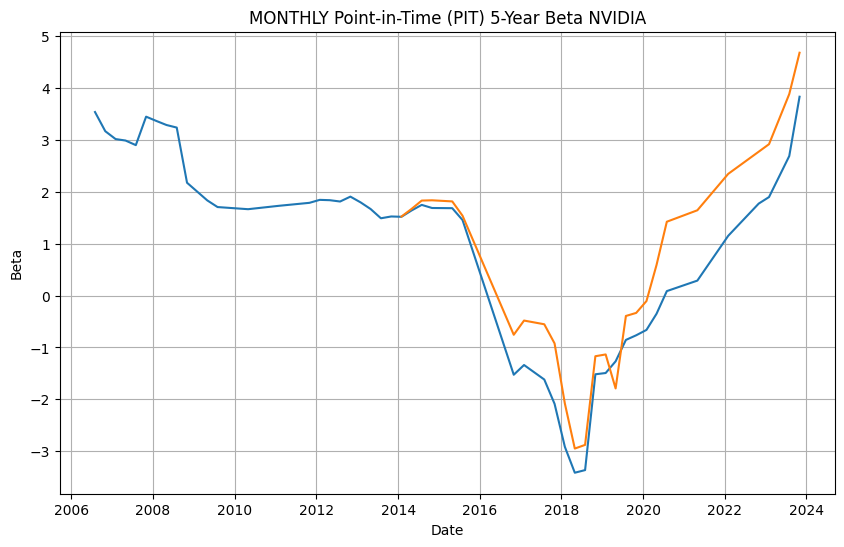

In [17]:
plt.figure(figsize=(10, 6))

plt.plot(combined_data['date'], combined_data['regular_beta'])
plt.plot(combined_data['date'], combined_data['cash_beta'])

plt.title('MONTHLY Point-in-Time (PIT) 5-Year Beta NVIDIA')
plt.xlabel('Date')
plt.ylabel('Beta')
plt.grid(True)
plt.show()

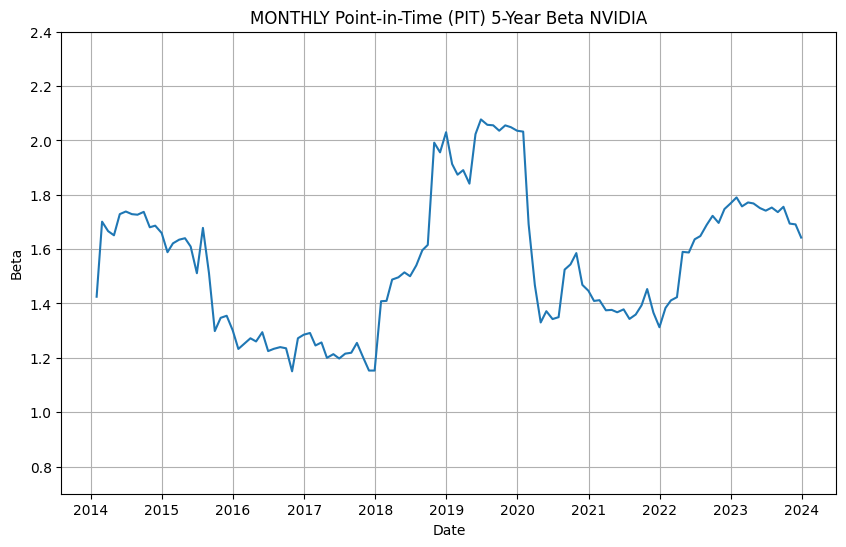

In [18]:
plt.figure(figsize=(10, 6))

for permno, group_data in monthly_df.groupby('permno'):
    plt.plot(group_data['date'], group_data['PIT_5Y_Beta'])

plt.title('MONTHLY Point-in-Time (PIT) 5-Year Beta NVIDIA')
plt.xlabel('Date')
plt.ylabel('Beta')
plt.ylim(0.7, 2.4)
plt.grid(True)
plt.show()